# AIS data processing documentation

## Introduction

Here is given the documentation of the Automatic Identification System (AIS) data processing. The aim of the AIS data processing is to tranform the data for integrating it with other data. The data transformation applied is the regularisatio in time. The outcome is a dataset in the form where the locations of ships are listed with 20 second intervals. The 20 second interval is the time step of the calculated one-third octave band sound pressure level data. This documentation lists in order: 
- Overview of the AIS data processed;
- Reading the data;
- Marking voyages for vessels in AIS data;
- Time regularizing of the AIS points;
- Adding distances and azimuths to the data;
- Creating time series of closest ships

The document ends with the overview of the current AIS data processing pipeline.

## BIAS AIS data overview

For exhaustive description for the AIS data I recommend the [AIS wikipedia page](https://en.wikipedia.org/wiki/Automatic_identification_system) and the [decoding documentation](https://gpsd.gitlab.io/gpsd/AIVDM.html). The AIS data processed was originally collected for the purposes of the [BIAS project](https://biasproject.wordpress.com/). The AIS data has also been processed previously and the results are published in articles [[Mustonen 2019]](https://www.nature.com/articles/s41598-019-48891-x) and [[Mustonen 2020]](https://asa.scitation.org/doi/full/10.1121/10.0000749). A map with the calculated ship traffic densities from the data is shown in the figure below.
<figure>
 <img src="Doc_figs/Density.png" alt="AIS data and sound monitoring locations" style="width:45%" />
 <figcaption>
 <b>Figure 1:</b> AIS data based ship traffic densities and sound monitoring locations. Published in <a href="https://asa.scitation.org/doi/full/10.1121/10.0000749">[Mustonen 2020]</a>
 </figcaption>
</figure>


As seen in the above figure the AIS data is concentrated around the four Estonian BIAS sound monitoring locations denoted by numbers **20**, **21**, **22**, and **23**. The data spans 20 km radius around all the sound monitoring locations.

The data for all the sound monitoring locations for the year 2014 was collected and saved in _.txt_ file format. For every monitoring location exists 12 of the files, one for each month of the year. The first few lines of the _.txt_ file look as following
in a table format looks like

|        DAY |     TIME |      MMSI |         LAT |         LON | Vs | TYPEc |  L1 | L2 | B1 | B2 | TYPEs | DRAUGHT | BIASST |           DISTKM |
|------------|----------|-----------|-------------|-------------|----|-------|-----|----|----|----|-------|---------|--------|------------------|
| 01-01-2014 | 18:02:17 | 310640000 |   55.205825 |    13.31618 | 15 |    70 | 190 | 39 | 19 | 13 |    17 |       7 |      2 | 19.1188469545512 |
| 01-01-2014 | 18:01:04 | 310640000 | 55.20629167 | 13.30748833 | 15 |    70 | 190 | 39 | 19 | 13 |    17 |       7 |      2 | 18.6783675948067 |
| 01-01-2014 | 17:57:59 | 310640000 |    55.20743 | 13.28499167 | 15 |    70 | 190 | 39 | 19 | 13 |    17 |       7 |      2 | 17.5740792317342 |
| 01-01-2014 | 17:53:28 | 310640000 | 55.20901167 |   13.252135 | 15 |    70 | 190 | 39 | 19 | 13 |    17 |       7 |      2 | 16.0628887633561 |

The data contains various different data columns, that can be divided into three separate categories:
 - __Instantaneous:__ position and speed of a vessel (__DAY, TIME, LAT, LON, Vs, DISTKM__)
 - __Voyage related:__ data of the vessel (__DRAUGHT__)
 - __Vessel related:__ data (__MMSI, TYPEc, L1, L2, B1, B2__)

The meaning and usefulness of the __TYPEs__ is obscure. The __BIASST__ corresponds to the monitoring location number around which the AIS data is from. Here we will go through the different categories and the data within them.

### Vessel related data

- __MMSI__ is the Maritime Mobile Service Identity of the vessel (https://en.wikipedia.org/wiki/Maritime_Mobile_Service_Identity). This is sort of like a phone number of a vessel (sometimes not only a vessel), as it also entails the code of the country where the ship is registred. The MMSI of a vessel can change. For example when they change their country of registration.
- __TYPEc__ is the two numbered code for the type of the vessel. It can be decoded to give name of the type of the ship. These categories can be somewhat broad.
- __L1, L2, B1, B2__ give the location of the AIS transponde onboard the ship by giving in meters
     - __L1__ Dimension to Bow
     - __L2__ Dimension to Stern
     - __B1__ Dimension to Port
     - __B2__ Dimension to Starboard

### Voyage related data

The only voyage related data availabe in this AIS data set is the __DRAUGHT__. This can be different for every voyage of the vessel. The draught of a vessels' hull is the vertical distance in meters between the waterline and the bottom of the hull (keel), with the thickness of the hull included. 

### Instantaneous AIS data

- __DAY, TIME__ gives the timestamp of the vessels position in day-month-year Hour:Minute:Second format. The timestamp is in __UTC__ Coordinated Universal Time.
- __LAT, LON__ the latitude and the longitude of the vessel in the World Geodetic System (WGS) coordinates.
- __Vs__ is the speed over ground of the vessel.
- __DISTKM__ is something not provided by AIS but a calculated distance in km to the sound monitoring location. This was probably added by a person dealing with the gathering of the AIS data in the BIAS project. This was not always calculated from the right location and the precision was left unreasonably high (tenth of a nanometer).

## Reading the AIS data

For reading the AIS data the function "_read_ais_"  was written inside the "_read_interp_ais_data.py_" file. The function takes as input the number denoting the sound location (__20__, __21__, __22__, __23__). The AIS data from one monitoring location is read from the files and added into a single pandas dataframe. The __TYPEs__ and the __BIASST__ are neglected in the process. The __DAY__ and __TIME__ are added together to give a single timestamp. The names of variables are also changed.

In [1]:
import os
import pandas as pd

def read_ais(location_name):
    """
    Function for reading the AIS data.
    input:  str format number denoting the sound monitoring location "20", "21", "22", "23"
    output: pandas dataframe containing all the AIS data from one monitoring location
    """
    ais_dir = 'AIS_BIASstations'  # Directory with monitoring location AIS data folders
    # List locations' monthly AIS data files
    ais_loc_path = os.path.join(ais_dir, 'BIAS' + location_name)
    # Filter out files except .txt files
    files_list = list(filter(lambda k: '.txt' in k, os.listdir(ais_loc_path)))
    k = 0
    # Loop through the monthly AIS data files
    for i_file in files_list:
        i_file = os.path.join(ais_loc_path, i_file)  # Construct file path for read
        data = pd.read_table(i_file, sep=';')  # Read the data from the file
        daytime = data.DAY + ' ' + data.TIME  # Add the date and time together into one timestamp

        # Construct a new dataframe with new variable names from the read data
        ais_data = pd.DataFrame(data={'Time': daytime, 'Latitude': data.LAT,
                                      'Longitude': data.LON, 'MMSI': data.MMSI,
                                      'Vs': data.Vs, 'Ship_type': data.TYPEc,
                                      'L1': data.L1, 'L2': data.L2, 'B1': data.B1,
                                      'B2': data.B2, 'Draught': data.DRAUGHT})

        # Convert the timestamp to the datetime format
        ais_data.Time = pd.to_datetime(ais_data.Time, format='%d-%m-%Y %H:%M:%S', utc=True)
        # Add the AIS data from one location together into one variable
        if k == 0:
            ais_data_l = ais_data.copy()  # Create a file to append first iteration data
            k = 1
        else:
            ais_data_l = ais_data_l.append(ais_data)  # Append to the data frame
    return ais_data_l  # return the pandas dataframe only

location_name = '23'
ais_data_l = read_ais(location_name)  # Use the read_ais function with location '21' as input
ais_data_l.iloc[[0,1,2,3]] # Display first four rows of the table

Time   Latitude  Longitude       MMSI  Vs  Ship_type  \
0 2014-12-01 00:34:45+00:00  57.822035  20.881730  212856000  14       70.0   
1 2014-12-01 00:33:58+00:00  57.819120  20.879828  212856000  14       70.0   
2 2014-12-01 02:02:59+00:00  58.141860  21.100860  212856000  14       70.0   
3 2014-12-01 02:00:42+00:00  58.133547  21.095250  212856000  14       70.0   

     L1    L2    B1   B2  Draught  
0  78.0  20.0  11.0  5.0      5.0  
1  78.0  20.0  11.0  5.0      5.0  
2  78.0  20.0  11.0  5.0      5.0  
3  78.0  20.0  11.0  5.0      5.0

## Mark voyages for vessels in AIS data

After the data is in the pandas dataframe format the next step is to prepare it for interpolatsion. The interpolation of ship locations can be done only for a single trip (voyage) of the ship passing the sound monitoring location. For this:
- Sort the data by the MMSI codes of ships;
- Add ship voyage number to data by using 20 minute time threshold;
- Create new column to the AIS data frame listing the voyage numbers.

Threfore, if time between consecutive single ship AIS position report > 20 min then point from different voyage. For marking the voyages in the AIS data the function "_read_add_voyages_ais_" was written inside the "_read_interp_ais_data.py_" file.

In [2]:
def read_add_voyages_ais(location_name):
    """
    Function for reading the AIS data and adding the voyage numbers to the data
    input:  str format number denoting the sound monitoring location "20", "21", "22", "23"
    output: pandas dataframe containing all the AIS data from one monitoring location with the
    Voyages variable listing the voyage numbers for different MMSI-s
    """
    ais_data_l = read_ais(location_name)  # read_ais function for reading the AIS data
    # Remove the data a ship has only one row in the dataframe
    ais_data_l = ais_data_l[ais_data_l.groupby('MMSI').MMSI.transform(len) > 1]

    ships = ais_data_l.MMSI.unique()  # Make a list of unique MMSI numbers
    time_thresh = int(20*60)  # Set the time threshold for comparing the data in int(min*seconds)
    time_dif_min = 15  # For filtering out points closer than 15 seconds in time
    # Loop through all the different MMSI numbers in the data
    for one_ship in ships:
        # Create dataframe with on MMSI AIS data only
        ais_one_ship = ais_data_l[ais_data_l.MMSI == one_ship]
        # Sort the AIS data according to time
        ais_one_ship = ais_one_ship.sort_values(by='Time')

        i_no = 0  # Assign numbers to ship voyages, the first voyage is numbered 0
        voyage_no = [0] * len(ais_one_ship) # Make list zeros for voyage numbers
        # Create empty list for filtering points closer > 15 s in time
        filter_ls = list(bytearray(len(ais_one_ship)))
        filter_ls[0] = True  # Set first to be True
        # Loop through all the AIS data points from a single ship
        for i in range(1, len(ais_one_ship)):
            # Calculate the time difference between two consecutive AIS data points in UNIX time
            i_time_dif = int(ais_one_ship.Time.values[i])/10.**9 - int(ais_one_ship.Time.values[i-1])/10.**9
            # If the time difference between two consecutive points is larger
            # than the time threshold the second point is from a new voyage of a ship
            if i_time_dif > time_thresh:
                i_no += 1
            voyage_no[i] = i_no  # Add the voyage number to the list of voyages
            # Check a wether points close in time and add result to list
            filter_ls[i] = i_time_dif > time_dif_min
        # Add the voyage numbers to the dataframe of the single ship
        ais_one_ship['Voyage'] = pd.Series(voyage_no, index=ais_one_ship.index)
        ais_one_ship = ais_one_ship[filter_ls]  # Filtering points closer > 15 s in time
        # If ships voyage only has one data point discard the data
        ais_one_ship = ais_one_ship[ais_one_ship.groupby('Voyage').Voyage.transform(len) > 1]
        if one_ship == ships[0]:
            ais_data_voy_l = ais_one_ship.copy()  # Create a df to append first iteration data
        else:
            ais_data_voy_l = ais_data_voy_l.append(ais_one_ship)  # Append to the df
    return ais_data_voy_l  # return the pandas dataframe only

location_name = '23'  # Set the location name
ais_data_voyages = read_add_voyages_ais(location_name)  # Use the read_add_voyages_AIS function with location name as input
ais_data_voyages.iloc[[10,11,12,13]] # Display four rows from the table

Time   Latitude  Longitude       MMSI  Vs  \
2643 2014-10-20 23:02:05+00:00  58.098602  21.024143  212856000  14   
2644 2014-10-20 23:08:13+00:00  58.111372  21.060357  212856000  13   
923  2014-11-12 08:40:06+00:00  57.807592  20.864658  212856000  15   
922  2014-11-12 08:41:20+00:00  57.812287  20.867735  212856000  15   

      Ship_type    L1    L2    B1   B2  Draught  Voyage  
2643       70.0  78.0  20.0  11.0  5.0      5.0       0  
2644       70.0  78.0  20.0  11.0  5.0      5.0       0  
923        70.0  78.0  20.0  11.0  5.0      NaN       1  
922        70.0  78.0  20.0  11.0  5.0      NaN       1

### Single ship voyages on a map

For finding possible bugs it is reasonable to plot the ship data on a map. In this phase it helps to control whether the time threshold was chosen correctly. This can be checked if data points from different voyage data are colored differently. Also the sound monitoring locations are loaded from the metadata file and the locations displayed on the map alongside the ships single voyage AIS data.

In [3]:
import folium  # Folium makes it easy to visualize data that’s been manipulated in Python on an interactive Leaflet map
import branca.colormap as cm # Function from library for adding colors from a color palette
import numpy as np # NumPy is the fundamental package for scientific computing with Python

ships = ais_data_l.MMSI.unique()
ais_one_ship = ais_data_voyages[ais_data_voyages.MMSI == ships[100]]

# Create a basemap by taking the mean of AIS latitude and longitude as a center point
m = folium.Map(location=[ais_one_ship.Latitude.values.mean(), ais_one_ship.Longitude.values.mean()], zoom_start=10)

n = ais_one_ship.Voyage.values[-1] + 1  # The voyages were numbered from 0. Take the last points voyage no. and add 1 to get the true no of voyages

# If less then 3 voyages use only two colors
if n < 4:
    cols = {0: 'blue', 1: 'red', 2: 'green'}
# If more than 2 voyages select the colors from a palette
else:
    cols = cm.linear.Set1_08.to_step(n=max(ais_one_ship.Voyage.values)+1, index=np.arange(0,n,1))
# Plot and color the points one-by-one
for i in range(len(ais_one_ship.Latitude.values)):
    if n > 3:
        folium.Circle(location=[ais_one_ship.Latitude.values[i], 
                                ais_one_ship.Longitude.values[i]],
                      color = cols(ais_one_ship.Voyage.values[i]),
                      radius = 100,
                     popup= 'MMSI: ' + str(ais_one_ship.MMSI.values[i]) + 
                      ', Type: ' + str(int(ais_one_ship.Ship_type.values[i])) + 
                      ', Time ' + str(ais_one_ship.Time.values[i])[:19]).add_to(m)
    else:
                folium.Circle(location=[ais_one_ship.Latitude.values[i], 
                                ais_one_ship.Longitude.values[i]],
                              color = cols[ais_one_ship.Voyage.values[i]],
                              radius = 100,
                              popup= 'MMSI: ' + str(ais_one_ship.MMSI.values[i]) + 
                      ', Type: ' + str(int(ais_one_ship.Ship_type.values[i])) + 
                      ', Time ' + str(ais_one_ship.Time.values[i])[:19]).add_to(m)

            
## Load the deployments meta data and display the selected sound monitoring locations on the map.
dep_meta_tab = pd.read_table('dep_meta_data.txt', sep=' ')  # Read the data from the meta data file

# Plot all the deployment locations on the map with pop up additional data
for i in range(len(dep_meta_tab.Latitude.values)):
    folium.Marker(location=[dep_meta_tab.Latitude.values[i],
                            dep_meta_tab.Longitude.values[i]],
                  popup='Location ' + str(dep_meta_tab.station.values[i]) + ', ' 
                  + dep_meta_tab.Stat_name.values[i] + ', Depth: ' + 
                  str(dep_meta_tab.Wat_dep.values[i]) + ' m').add_to(m)
m

## Time regularization of the AIS points

As seen in the table above the time intervals for the location reporting in AIS are irregular in time. Once the 
The time regularisation of the AIS data was necessary as the intervals for the systems location reporting are irregular in time. The reporting frequency is dependant on the rate of turn and speed of the ships as well as the class of AIS transceiver. 

The time regularization was implemented by interolating between the given data points with __cubic splines__. For interpolating the AIS data the function "_read_interpolate_ais_" was written inside the "_read_interp_ais_data.py_" file.

In [4]:
import numpy as np
from scipy.interpolate import CubicSpline

def read_interpolate_ais(location_name):
    """
    Function that reads AIS data, adds voyage no-s and interpolates the ship locations
    for a regular 20 second time step
    input:  str format number denoting the sound monitoring location "20", "21", "22", "23"
    output: ais_data_l - pandas dataframe containing interpolated AIS data with 20 s time steps
            ais_voyages_l - pandas dataframe containing ships voyages data length, width, draught
    """
    # read_add_voyages_ais function for reading the AIS data and adding voyage numbers
    ais_data_voy_l = read_add_voyages_ais(location_name)
    # Remove data if a voyage has less than 3 points
    ais_data_voy_l = ais_data_voy_l[ais_data_voy_l.groupby('Voyage').Voyage.transform(len) > 3]
    # Make new variable MMSI_Voy listing MMSI number and voyage number together in str format
    ais_data_voy_l["MMSI_Voy"] = ais_data_voy_l["MMSI"].astype("str") + ' ' + ais_data_voy_l["Voyage"].astype("str")
    # Make a list of unique MMSI_Voy numbers
    ships_voys = ais_data_voy_l.MMSI_Voy.unique()
    # Loop through all the different MMSI_Voy-s in the data
    for one_voy in ships_voys:
        # Subset data to be from one voyage of a single ship
        ais_one_ship_voy = ais_data_voy_l[ais_data_voy_l.MMSI_Voy == one_voy]
        # Convert the timestamps from dateimetime to UNIX time
        time = ais_one_ship_voy.Time.values.astype(int)/10.**9
        # Fit cubic splines through the existing Longitude and time data
        csx = CubicSpline(time, ais_one_ship_voy.Longitude.values)
        # Fit cubic splines through the existing Latitude and time data
        csy = CubicSpline(time, ais_one_ship_voy.Latitude.values)

        # Creata an array with one second unix time stamps from first to last point of one voyage of a ship
        n_time = np.arange(int(ais_one_ship_voy.Time.values[0])/10.**9,
                           int(ais_one_ship_voy.Time.values[-1])/10.**9 + 1)

        # Create a function select 20 sec multiple time stamps from 1 sec time stamps
        # t is True if the remainder when divided by 100 (i.e. the last two digits)
        # are in a list [0,20,40,80]
        sec_20_func = lambda t: t % 100 in [0, 20, 40, 60, 80]
        v_sec_20_func = np.vectorize(sec_20_func)  # Vectorize the functions

        n_time_20 = n_time[v_sec_20_func(n_time)]  # Select only timestamps for seconds 0,20,40
        lons_20 = csx(n_time_20).round(8)  # Int. Lons for 20 sec time steps, round 8 digits
        lats_20 = csy(n_time_20).round(8)  # Int. Lats for 20 sec time steps, round 8 digits

        # Put the interpolated data from one ships voyage in a single pd df
        ais_data = pd.DataFrame(data={'Time': n_time_20, 'Latitude': lats_20, 'Longitude': lons_20,
                                      'MMSI': ais_one_ship_voy.MMSI.values[0],
                                      'Voyage': ais_one_ship_voy.Voyage.values[0]})
        # Put the one ship voyage data of listed ship dimensions and draught in another pd df
        ais_voyages = ais_one_ship_voy[["MMSI", "Ship_type", "L1", "L2", "B1", "B2", "Voyage"]]
        ais_voyages = ais_voyages.drop_duplicates() # Drop duplicate rows from the df

        # Append if ship had more than one voyage passed the monitoring location
        if one_voy == ships_voys[0]:
            ais_data_l = ais_data.copy()  # Create a df to append first iteration data
            ais_voyages_l = ais_voyages.copy()  # Create a df to append first iteration data
        else:
            ais_data_l = ais_data_l.append(ais_data)  # Append to the df
            ais_voyages_l = ais_voyages_l.append(ais_voyages)  # Append to the df
    return ais_voyages_l, ais_data_l  # Return the pd df of ship positions and voyages data only

location_name = '23'  # Set the location name
ais_voyages, ais_data = read_interpolate_ais(location_name)  # Use the read_add_voyages_AIS function with location name as input

## Plot single ship time regularized AIS data

For checking the validity of the interpolation the data is plotted. Since the number of points is very large they are not as easily plotted on a map. For that reason a simple point plot is made. The original AIS data is shown with brown colored dots and the interpolated data with blue colored dots.

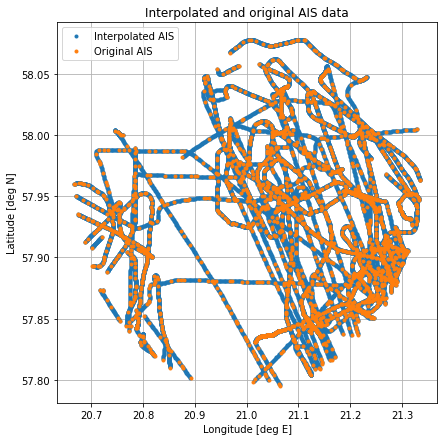

In [5]:
from matplotlib import pyplot as plt

ship = ais_data.MMSI.unique()[100]  # Select one ships' data to plot
ais_data_voyages_1 = ais_data_voyages[ais_data_voyages.MMSI == ship]
ais_data_1 = ais_data[ais_data.MMSI == ship]

%matplotlib inline

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(ais_data_1.Longitude.values, ais_data_1.Latitude.values, '.', label='Interpolated AIS')
ax.plot(ais_data_voyages_1.Longitude.values, ais_data_voyages_1.Latitude.values, '.', label='Original AIS')
plt.title('Interpolated and original AIS data')
plt.xlabel('Longitude [deg E]')
plt.ylabel('Latitude [deg N]')
plt.grid()
plt.legend()
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.show()

## Add distances and azimuths, create time series

Currently the interpolated data lists the coordinates of the ships. The distance and azimuth in relation to the sound monitoring location are also required for various purposes. For this purpose the function _calc_dist_az_ais_ was written inside the _create_ais_distance_ts.py_ file.

Instead of having the coordinates, distancez and azimuths for all the ships a time series dataframe with only the data from the closest ship would be useful. In many cases the closest ship contributes the most. For this purpose the function _make_ts_ais_ was written inside the _create_ais_distance_ts.py_ file.

In [6]:
import os
import pandas as pd
from datetime import datetime, timezone
from distance_az import distance_az


def calc_dist_az_ais(location_name):
    """
    Function calculating and adding distances, azimuths to the interpolated AIS data
    input:  str format number denoting the sound monitoring location "20", "21", "22", "23"
    output: pandas dataframe time-regularized AIS with calculated distance and azimuth
    """
    ais_dir = 'AIS_data_interpolated'  # Directory with monitoring location AIS data folders
    # File name of the AIS data to be read
    ais_int_file_name = 'B' + location_name + '_AIS_interpolated.csv'
    # Make full path of the AIS data file to be read
    ais_file_path = os.path.join(ais_dir, ais_int_file_name)

    ais_data_l = pd.read_csv(ais_file_path)  # Read the data from the file

    dep_meta_tab = pd.read_table('dep_meta_data.txt', sep=' ')  # Read deployment meta data
    # Subset deployment meta data for the station
    dep_meta_tab_st = dep_meta_tab[dep_meta_tab["station"] == int(location_name)].copy()

    k = 0
    for row in dep_meta_tab_st.itertuples():
        data_beg_t_n = datetime.strptime(str(row.Data_beg_t), '%Y%m%d%H%M%S')
        data_beg_t_d = data_beg_t_n.replace(tzinfo=timezone.utc).timestamp()

        data_end_t_n = datetime.strptime(str(row.Data_end_t), '%Y%m%d%H%M%S')
        data_end_t_d = data_end_t_n.replace(tzinfo=timezone.utc).timestamp()

        ais_data_l_s = ais_data_l[(ais_data_l["Time"] >= data_beg_t_d) &
                                  (ais_data_l["Time"] <= data_end_t_d)].copy()

        dist_dep, az_dep = distance_az(row.Longitude, row.Latitude,
                                       ais_data_l_s[['Longitude']].to_numpy(),
                                       ais_data_l_s[['Latitude']].to_numpy())

        ais_data_l_s['Distance'] = dist_dep
        ais_data_l_s['Azimuth'] = az_dep

        if k == 0:
            ais_data_l_l = ais_data_l_s
            k = 1
        else:
            ais_data_l_l = ais_data_l_l.append(ais_data_l_s)
    return ais_data_l_l

def make_ts_ais(location_name):
    """
    Function for reading the AIS data.
    input:  str format number denoting the sound monitoring location "20", "21", "22", "23"
    output: pandas dataframe containing all the AIS data from one monitoring location
    """
    ais_data_l_l = calc_dist_az_ais(location_name)
    ais_ts_l = ais_data_l_l.loc[ais_data_l_l.groupby('Time', sort=False)['Distance'].idxmin()]

    return ais_ts_l

loc_name = '23'
ais_ts = make_ts_ais(loc_name)

## Plot closest ship distance time series

The best overview of the outcome for composing the dataframe with closest ships' distances is given in the plot of time against the distance.

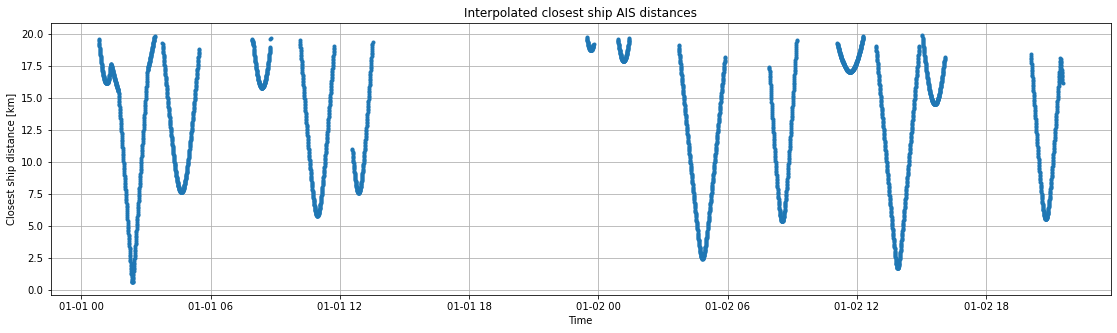

In [11]:
ais_ts = ais_ts.sort_values(by=['Time'])
ais_ts_s = ais_ts.head(3200)

time_stamp = pd.to_datetime(ais_ts_s['Time']*10**9)

fig, ax = plt.subplots(figsize=(19,5))

ax.plot(time_stamp, ais_ts_s.Distance.values, '.')
plt.title('Interpolated closest ship AIS distances')
plt.xlabel('Time')
plt.ylabel('Closest ship distance [km]')
plt.grid()
plt.show()

Not using extrapolation is probably the reason why the furthest distances are often less than 20 km. Some alarming cases seem to exist where a ship seems to appear suddenly $\approx$11 km away around 12:00 in 1.st January. For checking the outcome some more interactive plots should be made.

# Overview of the pipeline

For giving an overview of the steps taken in the AIS data processing the folders, script file names, function names are shown in __Figure 2__.

<figure>
 <img src="Doc_figs/AIS_processing_workflow.png" alt="AIS data and sound monitoring locations" style="width:90%" />
 <figcaption>
 <b>Figure 2:</b> AIS data processing pipeline overview
 </figcaption>
</figure>

As seen in __Fig. 2__ the AIS data pocessed is in the _AIS_BIASstations_ folder in monthly _.txt_ format files. The python file _read_interp_ais_data.py_ has functions for
- reading the data: _read_ais_
- reading and adding voyages: _read_add_voyages_ais_
- reading adding voyages and interpolating _read_interpolate_ais_

Using the _read_interpolate_ais_ function two types of dataframes are created:
1. Dataframe listing interpolated ship positions;
2. Dataframe listing ship ship lengths and draughts data

The dataframes are saved into the _AIS_data_interpolated_ folder. The python file's _create_ais_distance_ts.py_ function _calc_dist_az_ais_ uses the calculated interpolated ship positions and deployment meta data from _dep_meta_data.txt_ file to calculate the distances and azimuths for each ship location. Thereafter the _make_ts_ais_ function selects only the closest ship for each listed timestamp and the corresponding dataframe is saved to the _AIS_data_interpolated_ folder.